In [171]:
from astropy.io import fits
import matplotlib.pyplot as plt
import numpy as np
import astropy.units as u
from numpy import log10
import os 
from glob import glob
import warnings
from astropy.modeling.fitting import LevMarLSQFitter
from dust_extinction.shapes import FM90_B3
import pandas as pd
from scipy.interpolate import interp1d
import re

In [198]:
root_dir = r"C:\Users\kispz\OneDrive - Texas State University\REU MMA\Data\dirtygrid_dustony_2jun25"


fits_files = [f for f in glob(os.path.join(root_dir, "*", "*", "*", "*")) if f.endswith('.fits')]


# print (f"Found {len(fits_files)} FITS files")

In [149]:
def fit_fm90_to_attn(wavelength, flux, flux_input):
    if hasattr(wavelength, "unit"):
        wavelength = wavelength.value

    good = (flux > 0) & (flux_input > 0)
    wavelength = wavelength[good]
    flux = flux[good]

    A = -2.5 * np.log10(flux / flux_input)

    v_idx = np.argmin(np.abs(wavelength - 0.5629))
    b_idx = np.argmin(np.abs(wavelength - 0.4598))
    A_V = A[v_idx]
    A_B = A[b_idx]
    A_BV = A_B / A_V
    A_norm = A / A_V
    

    x = 1 / wavelength 
    y = A_norm

    mask = (x >= 2.857) & (x <= 11.111)
    x_uv = x[mask]
    y_uv = y[mask]

    y_uv_fm90 = (y_uv - 1) / (A_BV -1)

    fitter = LevMarLSQFitter()
    fm90_init = FM90_B3()
    with warnings.catch_warnings():
        warnings.simplefilter("ignore", category=UserWarning)
        fm90_fit = fitter(fm90_init, x_uv, y_uv_fm90, maxiter = 1100)
        fit_info = fitter.fit_info
        converged = fit_info.get("ierr", 0) in [1, 2, 3, 4]

    fm90_fit_vals = fm90_fit(x_uv) * (A_BV - 1) + 1
    fm90_init_vals = fm90_init(x_uv) * (A_BV -1) + 1

    return x_uv, y_uv, fm90_fit_vals, fm90_fit, fm90_init_vals, converged

def fit_fm90_to_ext(wavelength, tau):
    if hasattr(wavelength, "unit"):
        wavelength = wavelength.value
        
    A_ext = 1.086 * tau

    v_idx = np.argmin(np.abs(wavelength - 0.5629))
    b_idx = np.argmin(np.abs(wavelength - 0.4598))
    A_V = A_ext[v_idx]
    A_B = A_ext[b_idx]
    A_BV = A_B / A_V
    A_norm_ext = A_ext / A_V

    x = 1/wavelength
    y = A_norm_ext

    mask = (x >= 2.857) & (x <= 11.111)
    x_uv_ext = x[mask]
    y_uv_ext = y[mask]

    y_uv_fm90_ext = (y_uv_ext -1)/ (A_BV -1)

    fm90_init_ext = FM90_B3()
    fitter = LevMarLSQFitter()

    with warnings.catch_warnings():
        warnings.simplefilter('ignore', category = UserWarning)
        fm90_fit_ext = fitter(fm90_init_ext, x_uv_ext, y_uv_fm90_ext, maxiter = 1100)
        fit_info = fitter.fit_info
        converged_ext = fit_info.get('ierr', 0) in [1, 2, 3, 4]

    fm90_fit_vals_ext = fm90_fit_ext(x_uv_ext) * (A_BV - 1) + 1
    fm90_init_vals_ext = fm90_init_ext(x_uv_ext) * (A_BV - 1) + 1
    return x_uv_ext, y_uv_ext, y_uv_fm90_ext, fm90_fit_vals_ext, fm90_fit_ext, fm90_init_vals_ext, converged_ext

In [163]:
#check for 0.44 micron

for file_path in fits_files:
    with fits.open(file_path) as hdul:
        data = hdul[1].data
        wavelength = data['wavelength']
        print(data.columns)
        
        # # Strip units if needed
        # if hasattr(wavelength, 'unit'):
        #     wavelength = wavelength.value

        # # Get λ ≤ 0.55 & 0.47 μm
        # shortwave = wavelength[wavelength <= 0.47]

        # # Print results
        # print(f"\nFile: {os.path.basename(file_path)}")
        # print(f"λ ≤ 0.55 μm ({len(shortwave)} values):")
        # print(np.round(shortwave, 4))

ColDefs(
    name = 'wavelength'; format = 'E16.6'; unit = 'micron'; start = 1
    name = 'tau_norm'; format = 'E16.6'; unit = 'ratio'; start = 18
    name = 'Flux_Input'; format = 'E16.6'; unit = 'ergs s^-1 um^-1'; start = 35
    name = 'Flux'; format = 'E16.6'; unit = 'ergs s^-1 um^-1'; start = 52
    name = 'Flux_Unc'; format = 'E16.6'; unit = 'ergs s^-1 um^-1'; start = 69
    name = 'Flux_rt_d'; format = 'E16.6'; unit = 'ergs s^-1 um^-1'; start = 86
    name = 'Flux_rt_d_unc'; format = 'E16.6'; unit = 'ergs s^-1 um^-1'; start = 103
    name = 'Flux_rt_s'; format = 'E16.6'; unit = 'ergs s^-1 um^-1'; start = 120
    name = 'Flux_rt_s_unc'; format = 'E16.6'; unit = 'ergs s^-1 um^-1'; start = 137
    name = 'Flux_de_d_1'; format = 'E16.6'; unit = 'ergs s^-1 um^-1'; start = 154
    name = 'Flux_de_d_unc_1'; format = 'E16.6'; unit = 'ergs s^-1 um^-1'; start = 171
    name = 'Flux_de_s_1'; format = 'E16.6'; unit = 'ergs s^-1 um^-1'; start = 188
    name = 'Flux_de_s_unc_1'; format = 'E16.

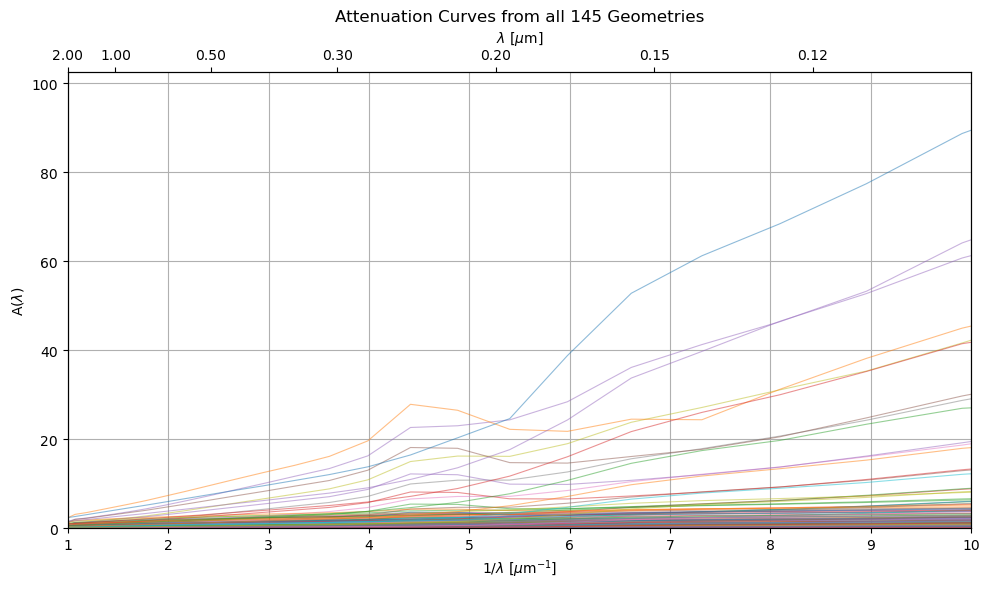

In [5]:
## Plotting all attenuation curves from all 145 geometries w/o normalization 

fig, ax = plt.subplots(figsize =  (10,6))

for file_path in fits_files: 
    with fits.open(file_path) as hdul: 
        data = hdul[1].data
        
        wavelength = data['wavelength'] * u.micron
        inv_lam = 1 / wavelength
        
        flux = data['flux']
        flux_input = data['flux_input']
        
        A = -2.5 * np.log10(flux/flux_input)
        
        ax.plot(inv_lam, A, alpha = 0.5, linewidth = 0.8)

ax.set_xlabel("1/$\lambda$ [$\mu$m$^{-1}$]")
ax.set_ylabel("A($\lambda$)")
ax.set_title("Attenuation Curves from all 145 Geometries")
ax.grid(True)
ax.set_xlim(1, 10)
ax.set_ylim(bottom = 0)

axis_xs = np.array([0.12, 0.15, 0.2, 0.3, 0.5, 1.0, 2.0])
new_ticks = 1.0 / axis_xs
new_ticks_labels = [f"{lam:.2f}" for lam in axis_xs]

tax = ax.twiny()
tax.set_xlim(ax.get_xlim())  # sync with 1/λ axis
tax.set_xticks(new_ticks)
tax.set_xticklabels(new_ticks_labels)
tax.set_xlabel(r"$\lambda$ [$\mu$m]")

# plt.axvline(x = 4.6)
plt.tight_layout()
plt.show()

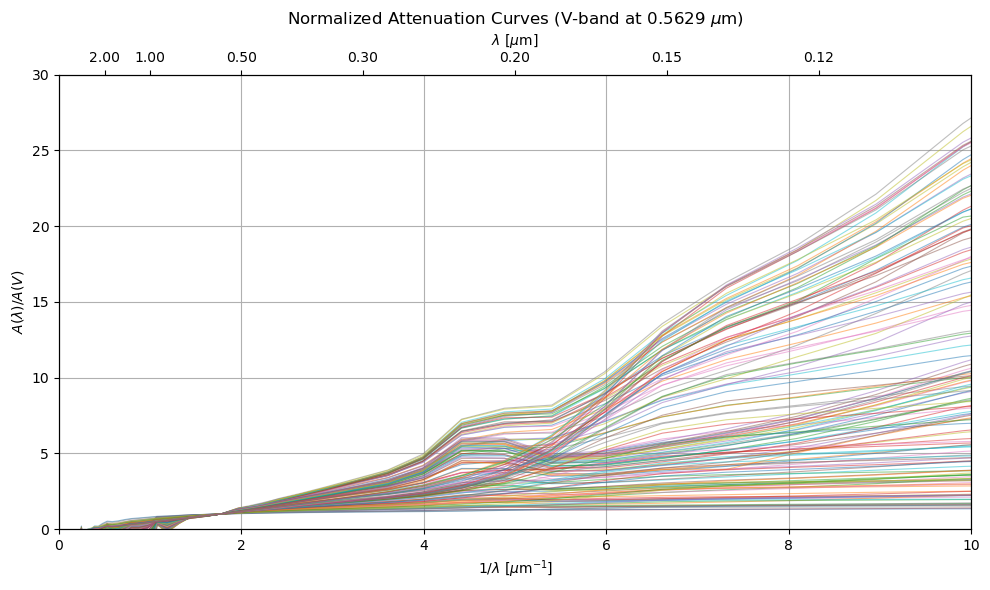

In [57]:
fig, ax = plt.subplots(figsize =  (10,6))

for file_path in fits_files: 
    with fits.open(file_path) as hdul: 
        data = hdul[1].data
        
        wavelength = data['wavelength']
        if hasattr(wavelength, 'unit'):
            wavelength = wavelength.value 
        inv_lam = 1 / wavelength
        
        flux = data['flux']
        flux_input = data['flux_input']
        
        A = -2.5 * np.log10(flux/flux_input)  

        #normalize at V-band (0.55 micron) The closest wavelength value we have is 5.629e-01 micron
        v_band_idx = np.argmin(np.abs(wavelength - 0.5629))
        A_V = A[v_band_idx]
        A_norm = A/A_V
        
        ax.plot(inv_lam, A_norm, alpha = 0.5, linewidth = 0.8)

ax.set_xlabel("1/$\lambda$ [$\mu$m$^{-1}$]")
ax.set_ylabel("$A(\lambda)/A(V)$")
ax.set_title("Normalized Attenuation Curves (V-band at 0.5629 $\mu$m)")
ax.grid(True)
ax.set_xlim(0, 10)
ax.set_ylim(bottom = 0, top = 30)

axis_xs = np.array([0.12, 0.15, 0.2, 0.3, 0.5, 1.0, 2.0])
new_ticks = 1.0 / axis_xs
new_ticks_labels = [f"{lam:.2f}" for lam in axis_xs]

tax = ax.twiny()

tax.set_xlim(ax.get_xlim())  # sync with 1/λ axis
tax.set_xticks(new_ticks)
tax.set_xticklabels(new_ticks_labels)
tax.set_xlabel(r"$\lambda$ [$\mu$m]")

plt.tight_layout()
plt.show()

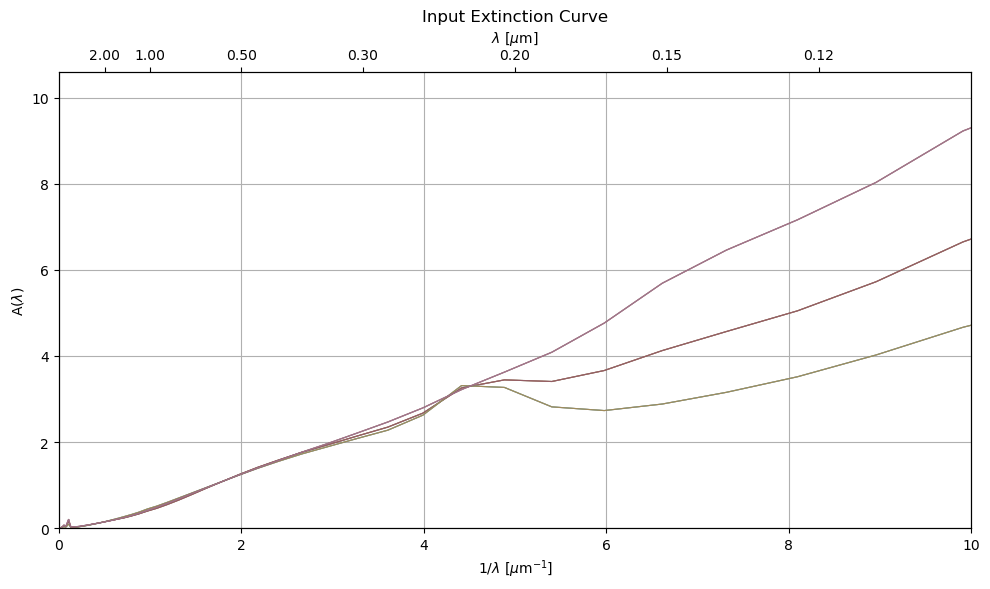

In [173]:
fig, ax = plt.subplots(figsize = (10,6))
for model in ["lmc2_bc10-wd01", "rv31_bc6-wd01", "smcbar-wd01"]:
    for geometry in ["cloudy", "dusty", "shell3"]:
        for dust_type in ["clumpy", "homo"]:
            folder = os.path.join(root_dir, model, geometry, dust_type)
            if not os.path.exists(folder):
                continue
            
            fits_files = [f for f in os.listdir(folder) if f.endswith('.fits')]
                        
            first_file = fits_files[0]
            file_path = os.path.join(folder, first_file)
            with fits.open(file_path) as hdul:
                data = hdul[1].data
                wavelength = data['wavelength'] *u.micron
                inv_lam = 1.0 / wavelength
                # if hasattr(wavelength, 'unit'):
                    # wavelength = wavelength.value     
                input_ext = data['tau_norm']
                # print(input_ext)
            
                A = 1.086 * input_ext
            
                ax.plot(inv_lam, A, alpha = 0.5, linewidth = 0.8)
                    
ax.set_xlabel("1/$\lambda$ [$\mu$m$^{-1}]$")
ax.set_ylabel("A($\lambda$)")
ax.set_title("Input Extinction Curve")
ax.grid(True)
ax.set_xlim(0,10)
ax.set_ylim(bottom = 0)

axis_xs = np.array([0.12, 0.15, 0.2, 0.3, 0.5, 1.0, 2.0])
new_ticks = 1.0 / axis_xs
new_ticks_labels = [f"{lam:.2f}" for lam in axis_xs]

tax = ax.twiny()
tax.set_xlim(ax.get_xlim())
tax.set_xticks(new_ticks)
tax.set_xticklabels(new_ticks_labels)
tax.set_xlabel(r"$\lambda$ [$\mu$m]")

plt.tight_layout()
plt.show()
        

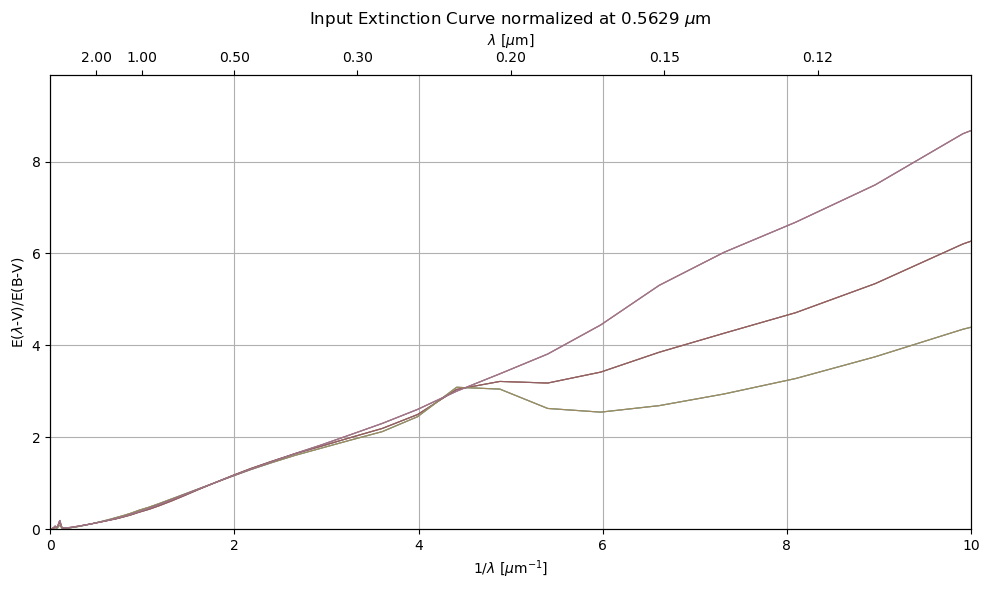

In [175]:
##Normalized at the V band 
fig, ax = plt.subplots(figsize = (10,6))
for model in ["lmc2_bc10-wd01", "rv31_bc6-wd01", "smcbar-wd01"]:
    for geometry in ["cloudy", "dusty", "shell3"]:
        for dust_type in ["clumpy", "homo"]:
            folder = os.path.join(root_dir, model, geometry, dust_type)
            if not os.path.exists(folder):
                continue
            
            fits_files = [f for f in os.listdir(folder) if f.endswith('.fits')]
                        
            first_file = fits_files[0]
            file_path = os.path.join(folder, first_file)
            with fits.open(file_path) as hdul:
                data = hdul[1].data
                wavelength = data['wavelength'] *u.micron
                inv_lam = 1.0 / wavelength
                if hasattr(wavelength, 'unit'):
                    wavelength = wavelength.value     
                input_ext = data['tau_norm']
                # print(input_ext)
            
                A = 1.086 * input_ext
                v_idx = np.argmin(np.abs(wavelength - 0.5629))
                A_V = A[v_idx]
                A_norm = A/A_V
        
                ax.plot(inv_lam, A_norm, alpha = 0.5, linewidth = 0.8)
       

ax.set_xlabel("1/$\lambda$ [$\mu$m$^{-1}]$")
ax.set_ylabel("E($\lambda$-V)/E(B-V)")
ax.set_title("Input Extinction Curve normalized at 0.5629 $\mu$m")
ax.grid(True)
ax.set_xlim(0,10)
ax.set_ylim(bottom = 0)

axis_xs = np.array([0.12, 0.15, 0.2, 0.3, 0.5, 1.0, 2.0])
new_ticks = 1.0 / axis_xs
new_ticks_labels = [f"{lam:.2f}" for lam in axis_xs]

tax = ax.twiny()
tax.set_xlim(ax.get_xlim())
tax.set_xticks(new_ticks)
tax.set_xticklabels(new_ticks_labels)
tax.set_xlabel(r"$\lambda$ [$\mu$m]")

plt.tight_layout()
plt.show()

C:\Users\kispz\anaconda3\Lib\site-packages\dust_extinction\helpers.py:30: UserWarning: x has no units, assuming x units are inverse microns
  warnings.warn(


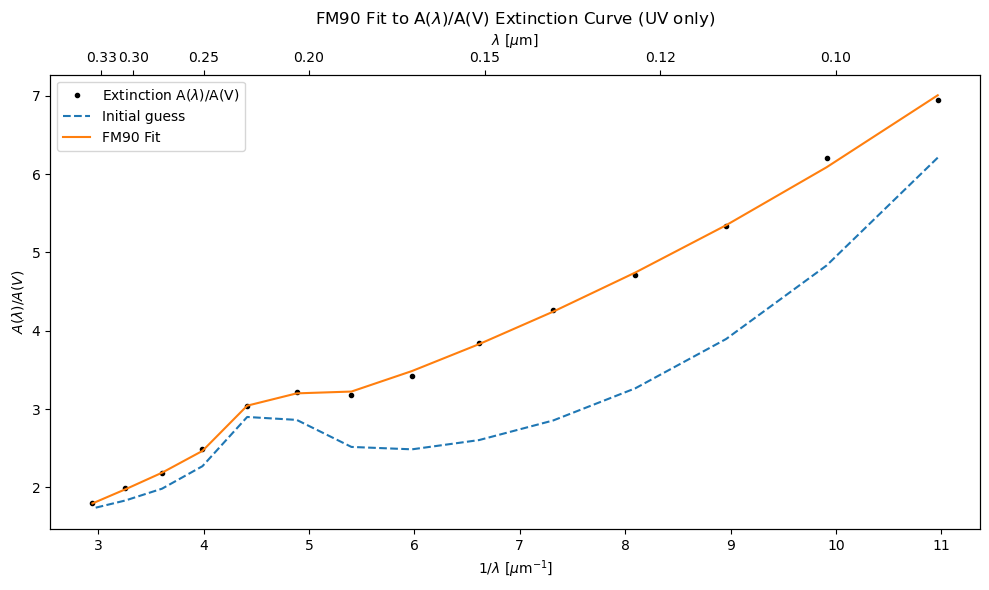

FM90 Best Fit Parameters:
C1 = -2.6381
C2 = 1.7383
B3 = 2.0345
C4 = 0.1217
x0 = 4.6032  (center of UV bump)
gamma = 0.6000  (width of bump)
{'nfev': 43, 'fvec': array([ 0.1994017 , -0.37353331,  0.01968229,  0.10507133, -0.05624003,
       -0.06434892,  0.21690347,  0.14012581, -0.03956289,  0.01516384,
       -0.08985253, -0.01747019, -0.05534057]), 'fjac': array([[-2.56067925e+01,  4.80833267e-01,  2.59819001e-01,
         1.24876806e-01,  4.85745789e-02,  1.15244875e-02,
         1.27855700e-04,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00,  0.00000000e+00,  0.00000000e+00,
         0.00000000e+00],
       [-1.75991536e+01, -1.73076295e+01,  2.82781372e-01,
         3.54934719e-01,  3.78891092e-01,  3.71709123e-01,
         3.45258631e-01,  3.12158211e-01,  2.82138367e-01,
         2.55006014e-01,  2.30481353e-01,  2.08316313e-01,
         1.88282870e-01],
       [-6.95261573e-03,  2.31286317e-01, -5.90245312e+00,
         1.37766132e-02,  1.64819100e-02,  2.10198233e-0

In [168]:
file_path = r"C:\Users\kispz\OneDrive - Texas State University\REU MMA\Data\dirtygrid_dustony_2jun25\lmc2_bc10-wd01\shell3\clumpy\lmc2_bc10-wd01_shell3_clumpy-s6.32456e+14-t0.5-m0.1-a1_global_lum.table.fits"
 
with fits.open(file_path) as hdul:
    data = hdul[1].data
    wavelength = data['wavelength']
    tau = data['tau_norm']
x_uv_ext, y_uv_ext, y_uv_fm90_ext, fm90_fit_vals_ext, fm90_fit_ext, fm90_init_vals_ext, converged_ext = fit_fm90_to_ext(wavelength, tau)


# plot
fig, ax = plt.subplots(figsize=(10, 6))

ax.plot(x_uv_ext, y_uv_ext, 'k.', label="Extinction A($\lambda$)/A(V)")
ax.plot(x_uv_ext, fm90_init_vals_ext, label="Initial guess", linestyle='--')
ax.plot(x_uv_ext, fm90_fit_vals_ext, label="FM90 Fit")

ax.set_xlabel(r"$1 / \lambda$ [$\mu$m$^{-1}$]")
ax.set_ylabel(r"$A(\lambda) / A(V)$")
ax.set_title("FM90 Fit to A($\lambda$)/A(V) Extinction Curve (UV only)")
ax.legend()

# Top axis 
axis_xs = np.array([0.10, 0.12, 0.15, 0.20, 0.25, 0.30, 0.33])
new_ticks = 1 / axis_xs  # positions in 1/micron
new_tick_labels = ["%.2f" % z for z in axis_xs]

tax = ax.twiny()
tax.set_xlim(ax.get_xlim())  
tax.set_xticks(new_ticks)
tax.set_xticklabels(new_tick_labels)
tax.set_xlabel(r"$\lambda$ [$\mu$m]")

plt.tight_layout()
plt.show()

# print parameters 
print("FM90 Best Fit Parameters:")
print(f"C1 = {fm90_fit_ext.C1.value:.4f}")
print(f"C2 = {fm90_fit_ext.C2.value:.4f}")
print(f"B3 = {fm90_fit_ext.B3.value:.4f}")
print(f"C4 = {fm90_fit_ext.C4.value:.4f}")
print(f"x0 = {fm90_fit_ext.xo.value:.4f}  (center of UV bump)")
print(f"gamma = {fm90_fit_ext.gamma.value:.4f}  (width of bump)")
print(fit_info)

C:\Users\kispz\anaconda3\Lib\site-packages\dust_extinction\helpers.py:30: UserWarning: x has no units, assuming x units are inverse microns
  warnings.warn(


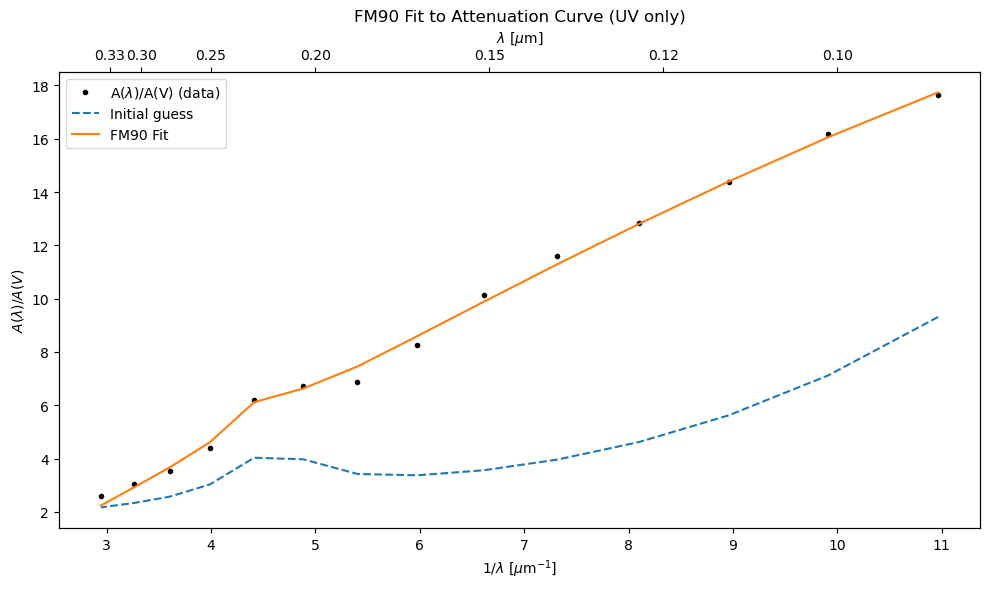

FM90 Best Fit Parameters:
C1 = -9.7772
C2 = 4.1410
B3 = 1.7916
C4 = -0.1150
x0 = 4.5000  (center of UV bump)
gamma = 0.6000  (width of bump)


In [166]:

file_path = r"C:\Users\kispz\OneDrive - Texas State University\REU MMA\Data\dirtygrid_dustony_2jun25\lmc2_bc10-wd01\shell3\clumpy\lmc2_bc10-wd01_shell3_clumpy-s6.32456e+14-t0.5-m0.1-a1_global_lum.table.fits"

with fits.open(file_path) as hdul:
    data = hdul[1].data
    wavelength = data['wavelength']
    flux = data['Flux']
    flux_input = data['Flux_input']
    
x_uv, y_uv, fm90_fit_vals, fm90_fit, fm90_init_vals, converged = fit_fm90_to_attn(wavelength, flux, flux_input)
    
fig, ax = plt.subplots(figsize=(10, 6))        
ax.plot(x_uv, y_uv, 'k.', label= "A($\lambda$)/A(V) (data)")
ax.plot(x_uv, fm90_init_vals, label="Initial guess", linestyle='--')
ax.plot(x_uv, fm90_fit_vals, label="FM90 Fit")

ax.set_xlabel(r"$1 / \lambda$ [$\mu$m$^{-1}$]")
ax.set_ylabel(r"$A(\lambda) / A(V)$")
# ax.set_ylim(0,20)
ax.set_title("FM90 Fit to Attenuation Curve (UV only)")
ax.legend()

# Top axis 
axis_xs = np.array([0.10, 0.12, 0.15, 0.20, 0.25, 0.30, 0.33])
new_ticks = 1 / axis_xs  # positions in 1/micron
new_tick_labels = ["%.2f" % z for z in axis_xs]

tax = ax.twiny()
tax.set_xlim(ax.get_xlim())  
tax.set_xticks(new_ticks)
tax.set_xticklabels(new_tick_labels)
tax.set_xlabel(r"$\lambda$ [$\mu$m]")


plt.tight_layout()
plt.show()

# print parameters 
print("FM90 Best Fit Parameters:")
print(f"C1 = {fm90_fit.C1.value:.4f}")
print(f"C2 = {fm90_fit.C2.value:.4f}")
print(f"B3 = {fm90_fit.B3.value:.4f}")
print(f"C4 = {fm90_fit.C4.value:.4f}")
print(f"x0 = {fm90_fit.xo.value:.4f}  (center of UV bump)")
print(f"gamma = {fm90_fit.gamma.value:.4f}  (width of bump)")
# print(fit_info)
# print(converged)

C:\Users\kispz\anaconda3\Lib\site-packages\dust_extinction\helpers.py:30: UserWarning: x has no units, assuming x units are inverse microns
  warnings.warn(
C:\Users\kispz\anaconda3\Lib\site-packages\dust_extinction\helpers.py:30: UserWarning: x has no units, assuming x units are inverse microns
  warnings.warn(
C:\Users\kispz\anaconda3\Lib\site-packages\dust_extinction\helpers.py:30: UserWarning: x has no units, assuming x units are inverse microns
  warnings.warn(
C:\Users\kispz\anaconda3\Lib\site-packages\dust_extinction\helpers.py:30: UserWarning: x has no units, assuming x units are inverse microns
  warnings.warn(
C:\Users\kispz\anaconda3\Lib\site-packages\dust_extinction\helpers.py:30: UserWarning: x has no units, assuming x units are inverse microns
  warnings.warn(
C:\Users\kispz\anaconda3\Lib\site-packages\dust_extinction\helpers.py:30: UserWarning: x has no units, assuming x units are inverse microns
  warnings.warn(
C:\Users\kispz\anaconda3\Lib\site-packages\dust_extinction

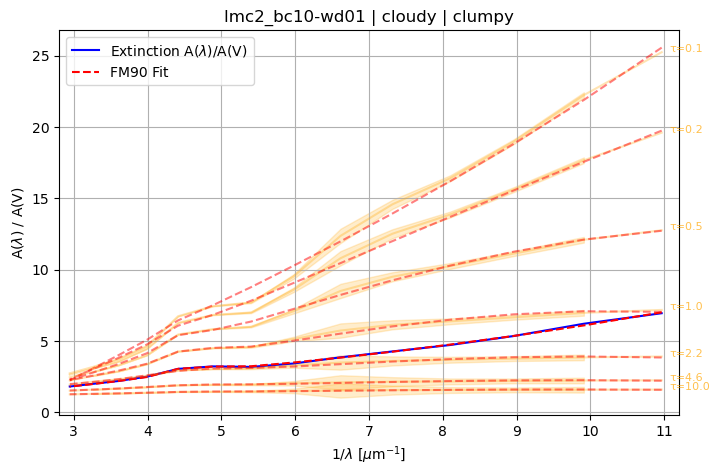

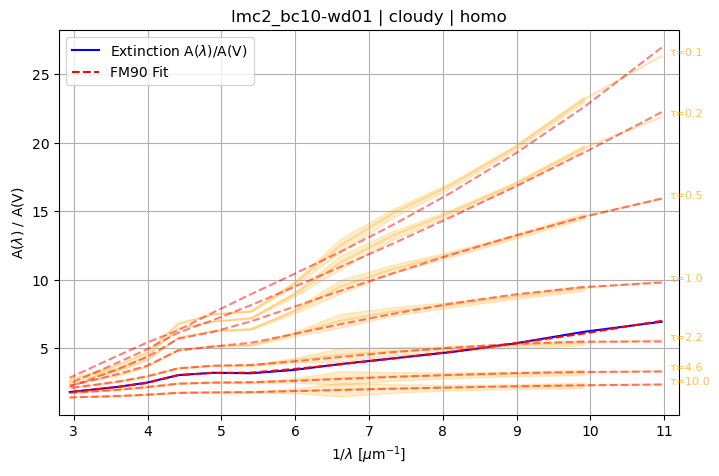

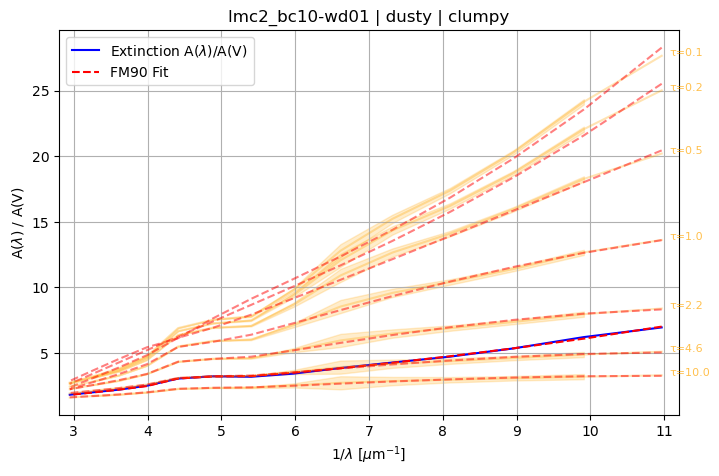

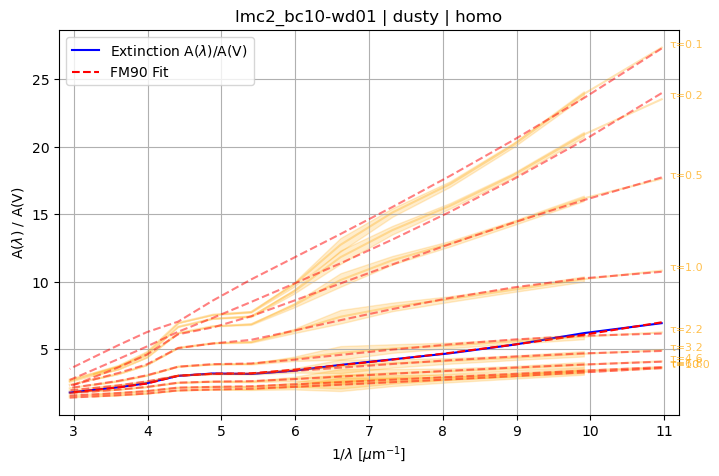

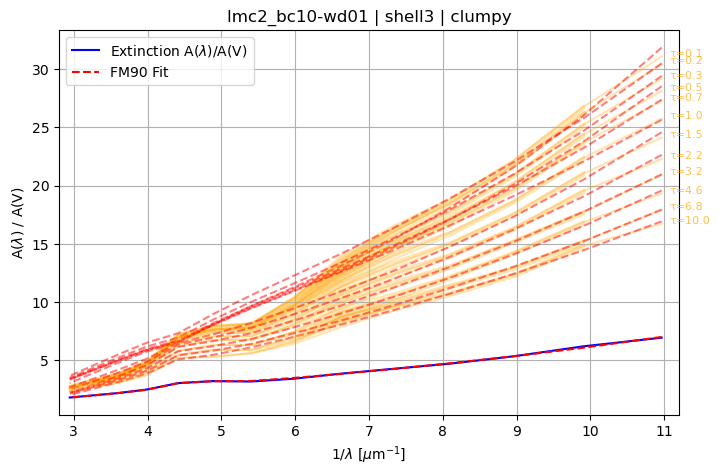

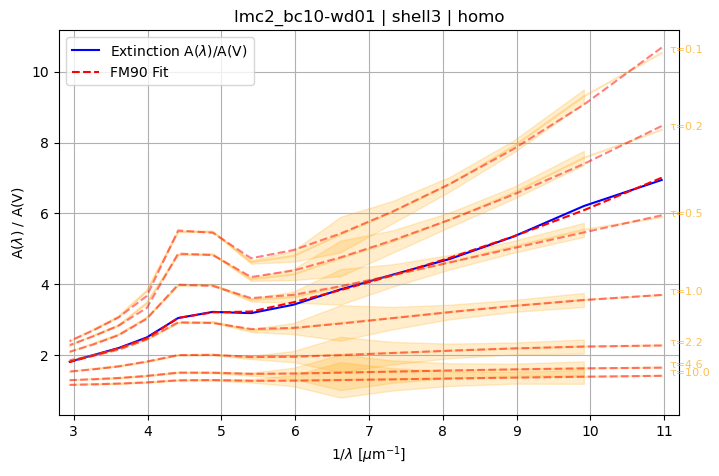

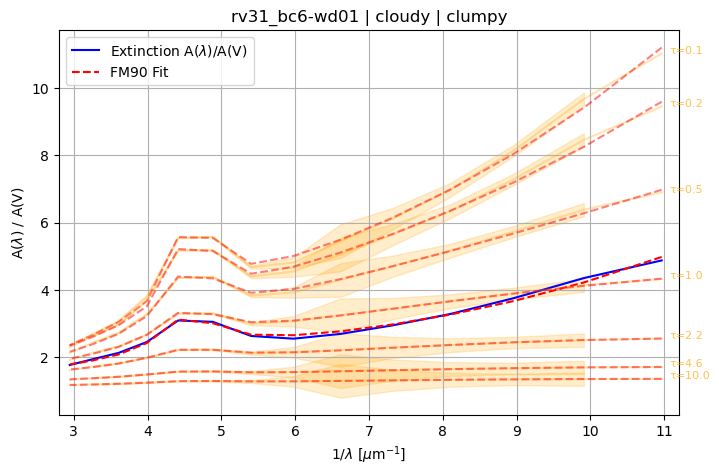

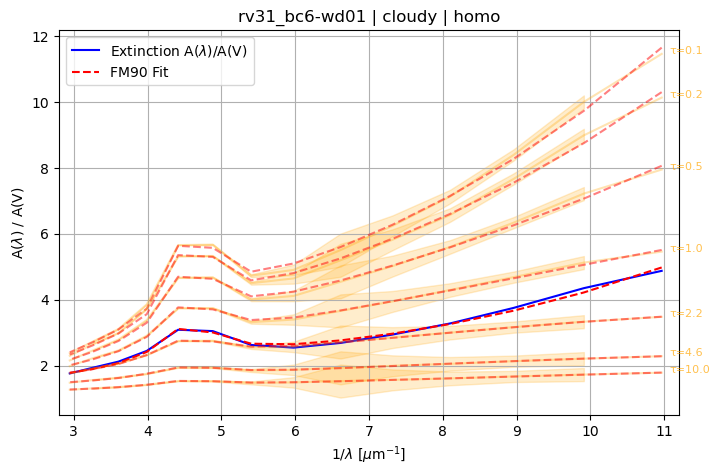

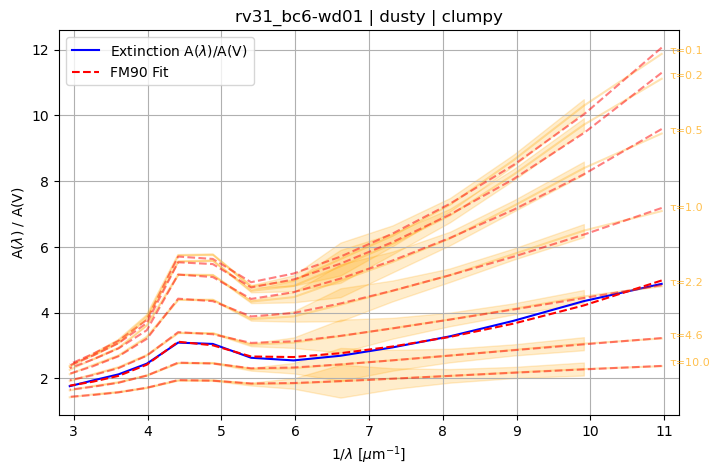

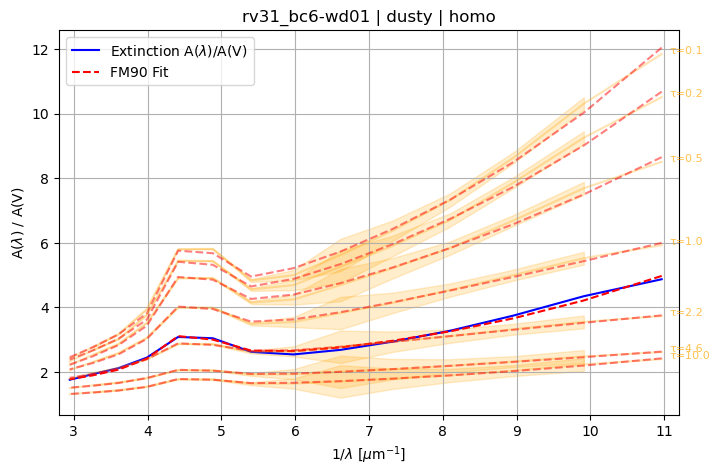

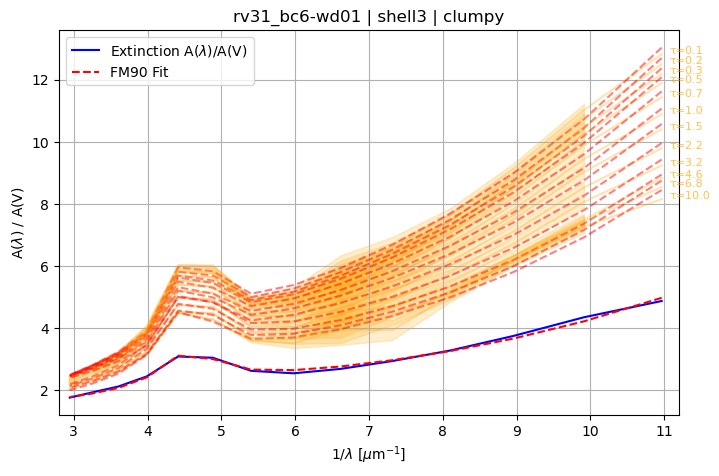

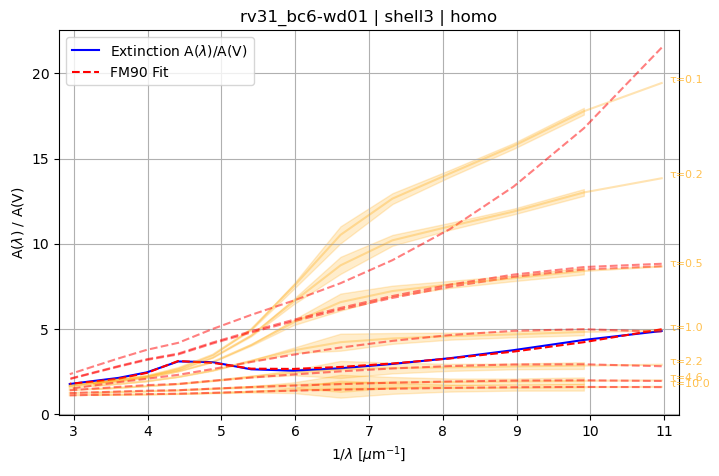

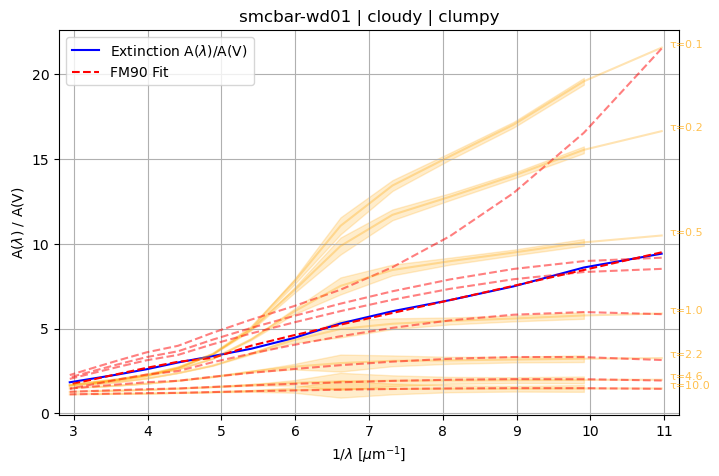

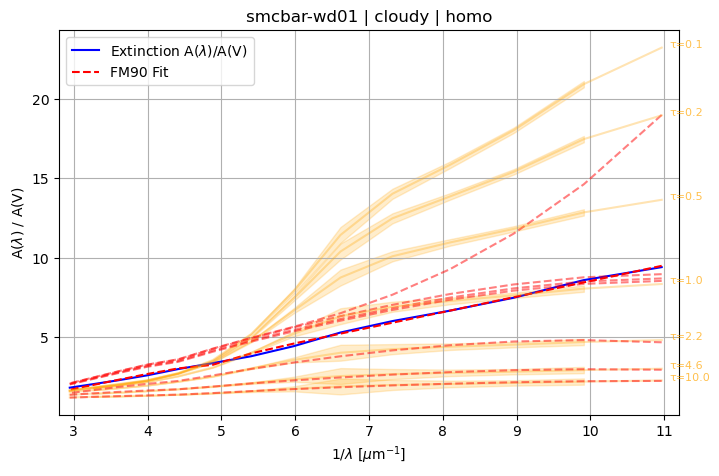

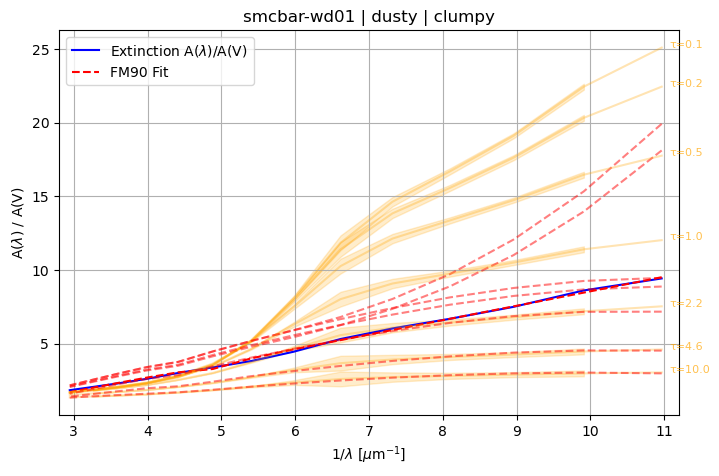

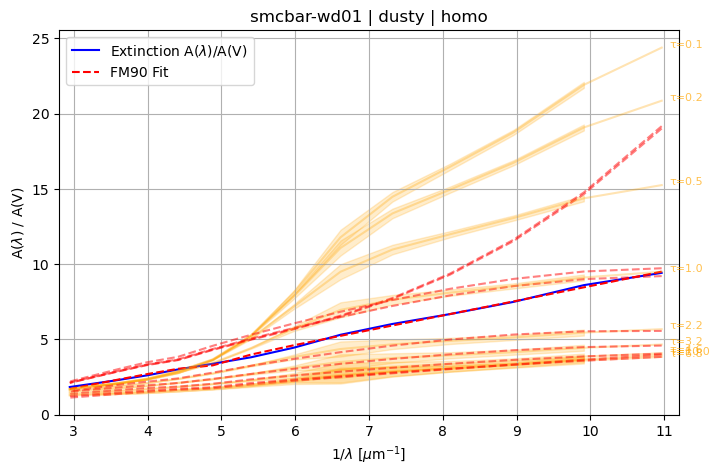

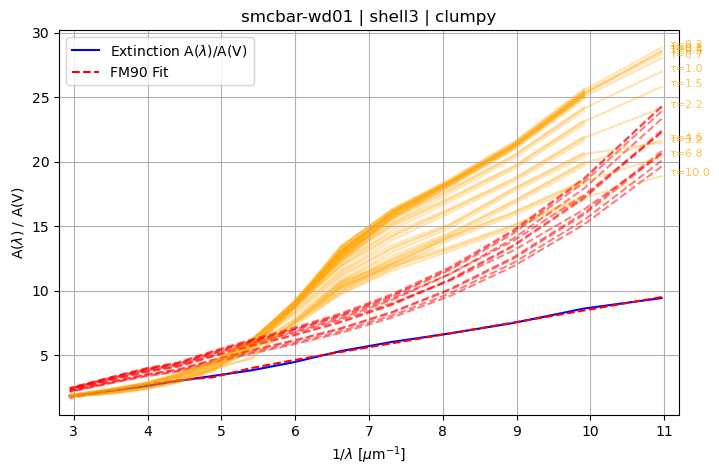

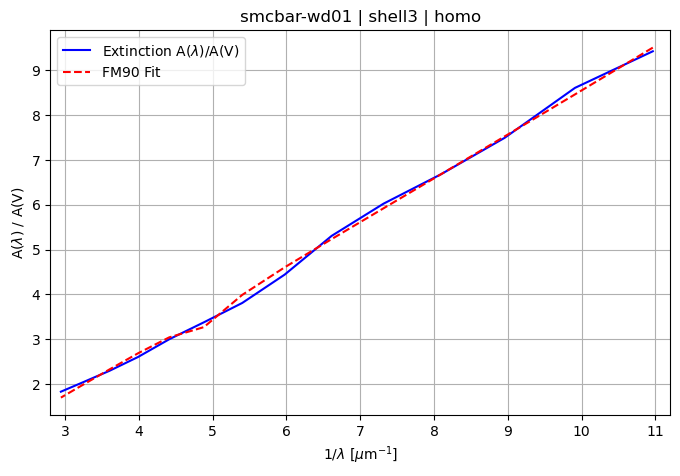

In [204]:
fitter = LevMarLSQFitter()

wavelength_grid = np.linspace(0.09, 0.32, 200)
x_grid = 1 / wavelength_grid

for model in ["lmc2_bc10-wd01", "rv31_bc6-wd01", "smcbar-wd01"]:
    for geometry in ["cloudy", "dusty", "shell3"]:
        for dust_type in ["clumpy", "homo"]:
            folder = os.path.join(root_dir, model, geometry, dust_type)
            if not os.path.exists(folder):
                continue

            atten_unc = []

            #Extinction curve for only the first file in the folder
            # Since the curve doesn't change with each fits file and only by model
            # We don't have to go through each file 
            fits_files = [f for f in os.listdir(folder) if f.endswith('.fits')]
            if not fits_files:
                continue
            
            first_file = fits_files[0]
            file_path = os.path.join(folder, first_file)
            
            with fits.open(file_path) as hdul:
                data = hdul[1].data
                wavelength = data['wavelength']
                if hasattr(wavelength, 'unit'):
                    wavelength = wavelength.value
                tau = data['tau_norm']
            #Using the def to convert to fm90 and back to A(lam)/A(V)     
            x_uv_ext, y_uv_ext, y_uv_fm90_ext, fm90_fit_vals_ext, fm90_fit_ext, fm90_init_vals_ext, converged_ext = fit_fm90_to_ext(wavelength, tau) 


            plotted_attn_label = False
            plotted_fit_label = False
                
            #Attenuation Curve for every file 
            for file in os.listdir(folder):
                if not file.endswith(".fits"):
                    continue
            
                file_path = os.path.join(folder, file)
                with fits.open(file_path) as hdul:
                    data = hdul[1].data
                    wavelength = data['wavelength']
                    
                    if hasattr(wavelength, 'unit'):
                        wavelength = wavelength.value
                        
                    flux = data['Flux']
                    flux_input = data['Flux_input']
                
                    ##Adding uncertainties 
                    #the uncertainty on A is propagated as: 
                    #     sigma_A = (2.5/ln(10)) * sqrt[(sigma_flux/flux)^2 + (sigma_fluxinput/ flux_input)^2]
                    #BUT: the FITS files only contain uncertainty on flux (Flux_Unc),
                    #     and not on flux_input
                    #I'm treating flux_input as exact (sigma_fluxinput = 0) and simplify to:
                    #     sigma_A = (2.5/ln(10)) * (sigma_flux/flux)
                    if "Flux_Unc" in data.columns.names:
                        flux_unc = data['Flux_Unc']
                        good = (flux > 0) & (flux_input > 0) & (flux_unc > 0)
                        flux = flux[good]
                        flux_input = flux_input[good]
                        flux_unc = flux_unc[good]
                        wavelength = wavelength[good]
                        
                        ln10 = np.log(10)
                        sigma_A = 2.5/ln10*(flux_unc/flux)
                        
                        sigma_interp = interp1d(wavelength, sigma_A, bounds_error = False, fill_value = np.nan)
                        atten_unc.append(sigma_interp(wavelength_grid))
                        
                #Converting to fm90 and back to A(lam)/A(V) for plotting
                x_uv, y_uv, fm90_fit_vals, fm90_fit, fm90_init_vals, converged = fit_fm90_to_attn(wavelength, flux, flux_input)

                #Plotting Attenuation curves 
                # label_data = None
                # label_fit = None
                
                label_data = "A($\lambda$)/A(V) (data)" 
                label_fit = "FM90 Fit (Attn)" 
                
                ax.plot(x_uv, y_uv, color="orange", alpha=0.3, label=label_data)
                ax.plot(x_uv, fm90_fit_vals, '--', color="red", alpha=0.5, label=label_fit)
                
                tau_str = file.split("-t")[1].split("-")[0]
                tau_val = float(tau_str)
                ax.text(x_uv[0] + 0.1, y_uv[0], f"τ={tau_val:.1f}", fontsize=8, color="orange", alpha=0.7)
                sigma = atten_unc[-1]
                interp_sigma = np.interp(x_uv, x_grid[::-1], sigma[::-1], left = np.nan, right = np.nan)
                mask = ~np.isnan(y_uv) & ~np.isnan(sigma_on_uv)
                sigma_label = "Attenuation ±1σ" if not plotted_sigma_label else None
                ax.fill_between(x_uv[mask],
                                y_uv[mask] - sigma_on_uv[mask],
                                y_uv[mask] + sigma_on_uv[mask],
                                color="orange", alpha=0.2, label=sigma_label)
                plotted_attn_label = True
                plotted_fit_label = True
                
                            
            
            # Plotting
            fig, ax = plt.subplots(figsize=(8, 5))
                   
            ax.plot(x_uv_ext, y_uv_ext, color = "blue", label="Extinction A($\lambda$)/A(V)")
            ax.plot(x_uv_ext, fm90_fit_vals_ext, '--', color = 'red', label="FM90 Fit")
            
           
            ax.set_xlabel("1/$\lambda$ [$\mu$m$^{-1}$]")
            ax.set_ylabel("A($\lambda$) / A(V)")  
            ax.set_title(f"{model} | {geometry} | {dust_type}")
            ax.set_xlim(2.8, 11.2)
            ax.legend()
            ax.grid(True)
            
            # # Save figure
            # save_name = f"{model}_{geometry}_{dust_type}_combined_fm90fit.png"
            # save_path = os.path.join(folder, save_name)
            # plt.savefig(save_path)
            # plt.close()
            
            # print(f" Saved combined plot: {save_path}")

